In [1]:
import math
import warnings

import numpy as np

import pypulseq as pp

In [2]:
seq_name = 'mese_leg'
# ======
# SETUP
# ======
dG = 250e-6

# Set system limits
system = pp.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=100,
    slew_unit="T/m/s",
    rf_ringdown_time=100e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

seq = pp.Sequence(system)  # Create a new sequence object
fov_x = 400e-3  # Define FOV and resolution
fov_y = 200e-3
Nx, Ny = 256, 128
n_echo = 17  # Number of echoes
n_slices = 8
rf_flip = 180  # Flip angle
if isinstance(rf_flip, int):
    rf_flip = np.zeros(n_echo) + rf_flip
rf_offset = 0
slice_thickness = 7e-3
slice_gap = 30e-3
TE = 11e-3  # Echo time and spacing
TR = 5000e-3  # Repetition time

sampling_time = 6.4e-3
readout_time = sampling_time + 2 * system.adc_dead_time
t_ex = 2.5e-3
t_exwd = t_ex + system.rf_ringdown_time + system.rf_dead_time
t_ref = 2e-3
t_refwd = t_ref + system.rf_ringdown_time + system.rf_dead_time
t_sp = 0.5 * (TE - readout_time - t_refwd)
t_spex = 0.5 * (TE - t_exwd - t_refwd)
fsp_r = 1
fsp_s = 0.5

rf_ex_phase = np.pi / 2
rf_ref_phase = 0


In [3]:
# ======
# CREATE EVENTS
# ======
flip_ex = 90 * np.pi / 180
rf_ex, gz, _ = pp.make_sinc_pulse(
    flip_angle=flip_ex,
    system=system,
    duration=t_ex,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=2,
    phase_offset=rf_ex_phase,
    return_gz=True,
)
gs_ex = pp.make_trapezoid(
    channel="z",
    system=system,
    amplitude=gz.amplitude,
    flat_time=t_exwd,
    rise_time=dG,
)

flip_ref = rf_flip[0] * np.pi / 180
rf_ref, gz, _ = pp.make_sinc_pulse(
    flip_angle=flip_ref,
    system=system,
    duration=t_ref,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=2,
    phase_offset=rf_ref_phase,
    use="refocusing",
    return_gz=True,
)
gs_ref = pp.make_trapezoid(
    channel="z",
    system=system,
    amplitude=gs_ex.amplitude,
    flat_time=t_refwd,
    rise_time=dG,
)

ags_ex = gs_ex.area / 2
gs_spr = pp.make_trapezoid(
    channel="z",
    system=system,
    area=ags_ex * (1 + fsp_s),
    duration=t_sp,
    rise_time=dG,
)
gs_spex = pp.make_trapezoid(
    channel="z", system=system, area=ags_ex * fsp_s, duration=t_spex, rise_time=dG
)

delta_k = 1 / fov_x
k_width = Nx * delta_k

gr_acq = pp.make_trapezoid(
    channel="x",
    system=system,
    flat_area=k_width,
    flat_time=readout_time,
    rise_time=dG,
)
adc = pp.make_adc(
    num_samples=Nx, duration=sampling_time, delay=system.adc_dead_time
)
gr_spr = pp.make_trapezoid(
    channel="x",
    system=system,
    area=gr_acq.area * fsp_r,
    duration=t_sp,
    rise_time=dG,
)

agr_spr = gr_spr.area
agr_preph = gr_acq.area / 2 + agr_spr
gr_preph = pp.make_trapezoid(
    channel="x", system=system, area=agr_preph, duration=t_spex, rise_time=dG
)

# Phase-encoding
phase_areas = (np.arange(Ny) - (Ny / 2)) / fov_y

In [4]:
# Split gradients and recombine into blocks
gs1_times = np.array([0, gs_ex.rise_time])
gs1_amp = np.array([0, gs_ex.amplitude])
gs1 = pp.make_extended_trapezoid(channel="z", times=gs1_times, amplitudes=gs1_amp)

gs2_times = np.array([0, gs_ex.flat_time])
gs2_amp = np.array([gs_ex.amplitude, gs_ex.amplitude])
gs2 = pp.make_extended_trapezoid(channel="z", times=gs2_times, amplitudes=gs2_amp)

gs3_times = np.array(
    [
        0,
        gs_spex.rise_time,
        gs_spex.rise_time + gs_spex.flat_time,
        gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time,
    ]
)
gs3_amp = np.array(
    [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
)
gs3 = pp.make_extended_trapezoid(channel="z", times=gs3_times, amplitudes=gs3_amp)

gs4_times = np.array([0, gs_ref.flat_time])
gs4_amp = np.array([gs_ref.amplitude, gs_ref.amplitude])
gs4 = pp.make_extended_trapezoid(channel="z", times=gs4_times, amplitudes=gs4_amp)

gs5_times = np.array(
    [
        0,
        gs_spr.rise_time,
        gs_spr.rise_time + gs_spr.flat_time,
        gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time,
    ]
)
gs5_amp = np.array([gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0])
gs5 = pp.make_extended_trapezoid(channel="z", times=gs5_times, amplitudes=gs5_amp)

gs7_times = np.array(
    [
        0,
        gs_spr.rise_time,
        gs_spr.rise_time + gs_spr.flat_time,
        gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time,
    ]
)
gs7_amp = np.array([0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude])
gs7 = pp.make_extended_trapezoid(channel="z", times=gs7_times, amplitudes=gs7_amp)

# Readout gradient
gr3 = gr_preph

gr5_times = np.array(
    [
        0,
        gr_spr.rise_time,
        gr_spr.rise_time + gr_spr.flat_time,
        gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time,
    ]
)
gr5_amp = np.array([0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude])
gr5 = pp.make_extended_trapezoid(channel="x", times=gr5_times, amplitudes=gr5_amp)

gr6_times = np.array([0, readout_time])
gr6_amp = np.array([gr_acq.amplitude, gr_acq.amplitude])
gr6 = pp.make_extended_trapezoid(channel="x", times=gr6_times, amplitudes=gr6_amp)

gr7_times = np.array(
    [
        0,
        gr_spr.rise_time,
        gr_spr.rise_time + gr_spr.flat_time,
        gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time,
    ]
)
gr7_amp = np.array([gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0])
gr7 = pp.make_extended_trapezoid(channel="x", times=gr7_times, amplitudes=gr7_amp)

In [5]:
# Fill-times
t_ex = pp.calc_duration(gs1) + pp.calc_duration(gs2) + pp.calc_duration(gs3)
t_ref = (
    pp.calc_duration(gs4)
    + pp.calc_duration(gs5)
    + pp.calc_duration(gs7)
    + readout_time
)
t_end = pp.calc_duration(gs4) + pp.calc_duration(gs5)

TE_train = t_ex + n_echo * t_ref + t_end
TR_fill = (TR - n_slices * TE_train) / n_slices # delay until next excitation pulse (not necessarily next TR, in case of interleaved multislice)
# Round to gradient raster
TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
if TR_fill < 0:
    TR_fill = 1e-3
    warnings.warn(
        f"TR too short, adapted to include all slices to: {1000 * n_slices * (TE_train + TR_fill)} ms"
    )
else:
    print(f"TR fill: {1000 * TR_fill} ms")
delay_TR = pp.make_delay(TR_fill)

TR fill: 428.61000000000007 ms


In [6]:
# ======
# CONSTRUCT SEQUENCE
# ======

# Prepare RF offsets. This is required for multi-slice acquisition
delta_z = (n_slices - 1)  * (slice_gap + slice_thickness)
z = np.linspace((-delta_z / 2), (delta_z / 2), n_slices) + rf_offset
print(delta_z)
print(z)

seq.add_block(pp.make_label(label="REV", type="SET", value=1)) # whyyyy?
for i in range(Ny):
    for s in range(n_slices):
        rf_ex.freq_offset = (
            gs_ex.amplitude * z[s]
        )
        rf_ref.freq_offset = (
            gs_ref.amplitude * z[s]
        )
        rf_ex.phase_offset = (
            rf_ex_phase
            - 2 * np.pi * rf_ex.freq_offset * pp.calc_rf_center(rf_ex)[0]
        )
        rf_ref.phase_offset = (
            rf_ref_phase
            - 2 * np.pi * rf_ref.freq_offset * pp.calc_rf_center(rf_ref)[0]
        )
        seq.add_block(gs1)
        seq.add_block(gs2, rf_ex)
        seq.add_block(gs3, gr3)
        for j in range(n_echo):
            gp_pre = pp.make_trapezoid(
                channel="y",
                system=system,
                area=phase_areas[-i -1],
                duration=t_sp,
                rise_time=dG,
            )
            gp_rew = pp.make_trapezoid(
                channel="y",
                system=system,
                area=-phase_areas[-i -1],
                duration=t_sp,
                rise_time=dG,
            )
            seq.add_block(gs4, rf_ref)
            seq.add_block(gs5, gr5, gp_pre)
            seq.add_block(gr6, adc)
            seq.add_block(gs7, gr7, gp_rew)
            if j != n_echo-1:
                seq.add_block(pp.make_label(type="INC", label="ECO", value=1))
            else:
                seq.add_block(pp.make_label(type="SET", label="ECO", value=0))
        # end
        seq.add_block(gs4)
        seq.add_block(gs5)
        seq.add_block(delay_TR)
        if s != n_slices-1:
            seq.add_block(pp.make_label(type="INC", label="SET", value=1))
        else:
            seq.add_block(pp.make_label(type="SET", label="SET", value=0),
                          pp.make_label(type="INC", label="LIN", value=1))
    # end
# end
(
    ok,
    error_report,
) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    #[print(e) for e in error_report]

0.259
[-0.1295 -0.0925 -0.0555 -0.0185  0.0185  0.0555  0.0925  0.1295]
Timing check passed successfully


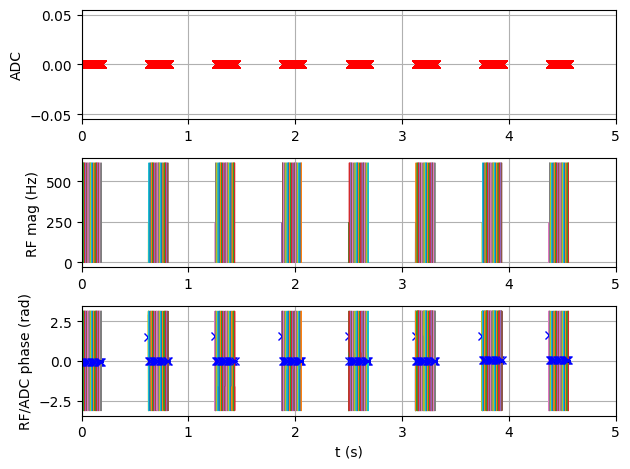

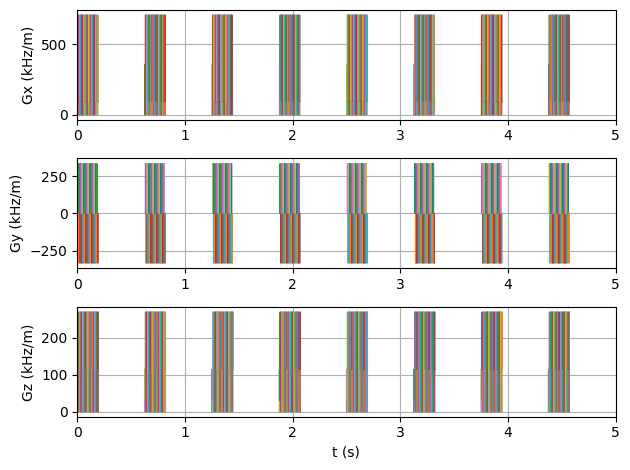

In [7]:
# ======
# VISUALIZATION
# ======
seq.plot(time_range=(0, TR))

In [8]:
# =========
# WRITE .SEQ
# =========
#if write_seq:
seq.set_definition(key="FOV", value=[fov_x, fov_y, delta_z+slice_thickness])
seq.set_definition(key="Name", value="mese")
seq.write(seq_name + '.seq')

'0e64c1aef3eeae12fd955170775dd5d8'

In [9]:
#write echo times into json
import json
bids_header = {
'EchoTime': (np.arange(1,n_echo+1)*TE*1000).tolist(),
'RefocusingFlipAngle': rf_flip[0],
'SliceThickness': slice_thickness*1000,
'Resolution': (fov_x/Nx*1000, fov_y/Ny*1000),
'FourthDimension': 'EchoTime',
'ScanningSequence': 'SE',
'MRAcquisitionType': '2D',
'PulseSequenceType': 'Multi-echo Spin Echo'
}
with open(seq_name + '.json', 'w') as f:
    json.dump(bids_header, f, indent=2)
print(bids_header)

{'EchoTime': [11.0, 22.0, 33.0, 44.0, 54.99999999999999, 66.0, 77.0, 88.0, 98.99999999999999, 109.99999999999999, 121.0, 132.0, 143.0, 154.0, 164.99999999999997, 176.0, 187.0], 'RefocusingFlipAngle': 180.0, 'SliceThickness': 7.0, 'Resolution': (1.5625, 1.5625), 'FourthDimension': 'EchoTime', 'ScanningSequence': 'SE', 'MRAcquisitionType': '2D', 'PulseSequenceType': 'Multi-echo Spin Echo'}
